
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>




# MLflow

<a href="https://mlflow.org/docs/latest/concepts.html" target="_blank">MLflow</a> seeks to address these three core issues:

* It’s difficult to keep track of experiments
* It’s difficult to reproduce code
* There’s no standard way to package and deploy models

In the past, when examining a problem, you would have to manually keep track of the many models you created, as well as their associated parameters and metrics. This can quickly become tedious and take up valuable time, which is where MLflow comes in.

MLflow is pre-installed on the Databricks Runtime for ML.

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) Learning Objectives:<br>

By the end of this lesson, you should be able to;

* Utilize MLflow to track experiments and log metrics
* Query and view past runs programmatically
* Search and view past runs using MLflow UI
* Save and reload models using MLflow

## 📌 Requirements

**Required Databricks Runtime Version:** 
* Please note that in order to run this notebook, you must use one of the following Databricks Runtime(s): **12.2.x-cpu-ml-scala2.12**

## Lesson Setup

The first thing we're going to do is to **run setup script**. This script will define the required configuration variables that are scoped to each user.

In [0]:
%run "./Includes/Classroom-Setup"

Python interpreter will be restarted.
Python interpreter will be restarted.


Resetting the learning environment:
| No action taken

Skipping install of existing datasets to "dbfs:/mnt/dbacademy-datasets/scalable-machine-learning-with-apache-spark/v02"

Validating the locally installed datasets:
| listing local files...(4 seconds)
| validation completed...(4 seconds total)

Creating & using the schema "charlie_ohara_4mi2_da_sml" in the catalog "hive_metastore"...(1 seconds)

Predefined tables in "charlie_ohara_4mi2_da_sml":
| -none-

Predefined paths variables:
| DA.paths.working_dir: dbfs:/mnt/dbacademy-users/charlie.ohara@standard.ai/scalable-machine-learning-with-apache-spark
| DA.paths.user_db:     dbfs:/mnt/dbacademy-users/charlie.ohara@standard.ai/scalable-machine-learning-with-apache-spark/database.db
| DA.paths.datasets:    dbfs:/mnt/dbacademy-datasets/scalable-machine-learning-with-apache-spark/v02

Setup completed (16 seconds)



## MLflow Architecture

<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/mlflow-tracking.png" style="height: 400px; margin: 20px"/></div>


## Load Dataset

Let's start by loading in our SF Airbnb Dataset.

In [0]:
file_path = "dbfs:/mnt/dbacademy-datasets/scalable-machine-learning-with-apache-spark/v02/airbnb/sf-listings/sf-listings-2019-03-06-clean.delta/"
airbnb_df = spark.read.format("delta").load(file_path)

train_df, test_df = airbnb_df.randomSplit([.8, .2], seed=42)
print(train_df.cache().count())

5786





## MLflow Tracking

MLflow Tracking is a logging API specific for machine learning and agnostic to libraries and environments that do the training.  It is organized around the concept of **runs**, which are executions of data science code.  Runs are aggregated into **experiments** where many runs can be a part of a given experiment and an MLflow server can host many experiments.

You can use <a href="https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_experiment" target="_blank">mlflow.set_experiment()</a> to set an experiment, but if you do not specify an experiment, it will automatically be scoped to this notebook.




### Track Runs

Each run can record the following information:<br><br>

- **Parameters:** Key-value pairs of input parameters such as the number of trees in a random forest model
- **Metrics:** Evaluation metrics such as RMSE or Area Under the ROC Curve
- **Artifacts:** Arbitrary output files in any format.  This can include images, pickled models, and data files
- **Source:** The code that originally ran the experiment

**NOTE**: For Spark models, MLflow can only log PipelineModels.

In [0]:
import mlflow
import mlflow.spark
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# this block of code starts a ML flow run which will create an experiment under the Machine Learning Experiments tab
with mlflow.start_run(run_name="LR-Single-Feature") as run:
    # Define pipeline 
    # Example used in our first attempt only using bedrooms to predict the price
    vec_assembler = VectorAssembler(inputCols=["bedrooms"], outputCol="features")
    lr = LinearRegression(featuresCol="features", labelCol="price")
    pipeline = Pipeline(stages=[vec_assembler, lr])
    pipeline_model = pipeline.fit(train_df)

    # Log parameters
    mlflow.log_param("label", "price")
    # Defining the features makes it easier to track what features were used to predict price
    mlflow.log_param("features", "bedrooms")

    # Log model
    # Use a sample of data to log the performance
    mlflow.spark.log_model(pipeline_model, "model", input_example=train_df.limit(5).toPandas()) 

    # Evaluate predictions
    pred_df = pipeline_model.transform(test_df)
    regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")
    rmse = regression_evaluator.evaluate(pred_df)

    # Log metrics
    mlflow.log_metric("rmse", rmse)

2024/02/09 15:46:37 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")





There, all done! Let's go through the other two linear regression models and then compare our runs. 

**Question**: Does anyone remember the RMSE of the other runs?

Next let's build our linear regression model but use all of our features.

In [0]:
from pyspark.ml.feature import RFormula

# run again using all features not just bedroom to predict price - can easily compare to previous model created 
with mlflow.start_run(run_name="LR-All-Features") as run:
    # Create pipeline
    r_formula = RFormula(formula="price ~ .", featuresCol="features", labelCol="price", handleInvalid="skip")
    lr = LinearRegression(labelCol="price", featuresCol="features")
    pipeline = Pipeline(stages=[r_formula, lr])
    pipeline_model = pipeline.fit(train_df)

    # Log pipeline
    mlflow.spark.log_model(pipeline_model, "model", input_example=train_df.limit(5).toPandas())

    # Log parameter
    mlflow.log_param("label", "price")
    mlflow.log_param("features", "all_features")

    # Create predictions and metrics
    pred_df = pipeline_model.transform(test_df)
    regression_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")
    rmse = regression_evaluator.setMetricName("rmse").evaluate(pred_df)
    r2 = regression_evaluator.setMetricName("r2").evaluate(pred_df)

    # Log both metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

2024/02/09 15:53:59 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().





Finally, we will use Linear Regression to predict the log of the price, due to its log normal distribution. 

We'll also practice logging artifacts to keep a visual of our log normal histogram.

2024/02/09 15:59:45 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


<Figure size 432x288 with 0 Axes>

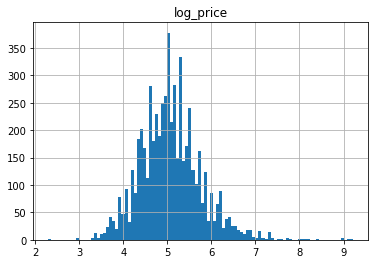

In [0]:
from pyspark.sql.functions import col, log, exp
import matplotlib.pyplot as plt

# final run to use log price instead of price to avoid outliers messing up the price prediction
with mlflow.start_run(run_name="LR-Log-Price") as run:
    # Take log of price
    log_train_df = train_df.withColumn("log_price", log(col("price")))
    log_test_df = test_df.withColumn("log_price", log(col("price")))

    # Log parameter
    mlflow.log_param("label", "log_price")
    mlflow.log_param("features", "all_features")

    # Create pipeline
    r_formula = RFormula(formula="log_price ~ . - price", featuresCol="features", labelCol="log_price", handleInvalid="skip")  
    lr = LinearRegression(labelCol="log_price", predictionCol="log_prediction")
    pipeline = Pipeline(stages=[r_formula, lr])
    pipeline_model = pipeline.fit(log_train_df)

    # Log model - this is what creates the experiment in the Machine Learning Experiments tab
    mlflow.spark.log_model(pipeline_model, "log-model", input_example=log_train_df.limit(5).toPandas())

    # Make predictions
    pred_df = pipeline_model.transform(log_test_df)
    exp_df = pred_df.withColumn("prediction", exp(col("log_prediction")))

    # Evaluate predictions
    rmse = regression_evaluator.setMetricName("rmse").evaluate(exp_df)
    r2 = regression_evaluator.setMetricName("r2").evaluate(exp_df)

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    # Log artifact
    plt.clf()

    # create an image showing the log price
    log_train_df.toPandas().hist(column="log_price", bins=100)
    fig = plt.gcf()
    mlflow.log_figure(fig, "log_normal.png")
    plt.show()




That's it! Now, let's use MLflow to easily look over our work and compare model performance. You can either query past runs programmatically or use the MLflow UI.




### Querying Past Runs Programmatically

You can query past runs programmatically in order to use this data back in Python.  The pathway to doing this is an **`MlflowClient`** object.

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

In [0]:
display(client.search_experiments())

_artifact_location,_creation_time,_experiment_id,_last_update_time,_lifecycle_stage,_name,_tags
dbfs:/databricks/mlflow-tracking/3021276973846949,1707493578655,3021276973846949,1707494307127,active,/Users/charlie.ohara@standard.ai/scalable-machine-learning-with-apache-spark/ml_04_mlflow_tracking,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 6043631322962989, mlflow.experiment.sourceName -> /Users/charlie.ohara@standard.ai/scalable-machine-learning-with-apache-spark/ml_04_mlflow_tracking, mlflow.ownerEmail -> charlie.ohara@standard.ai)"
dbfs:/databricks/mlflow-tracking/1567971800020335,1701982839474,1567971800020335,1701982839474,active,/jobs/pubsub_hedwig,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 7963407635181822, mlflow.experiment.sourceName -> /jobs/pubsub_hedwig, mlflow.ownerEmail -> anirudh@standard.ai)"
dbfs:/databricks/mlflow-tracking/3243878154968493,1701395579079,3243878154968493,1701395579079,active,/Users/anirudh@standard.ai/ad hoc/query any table,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 7963407635181822, mlflow.experiment.sourceName -> /Users/anirudh@standard.ai/ad hoc/query any table, mlflow.ownerEmail -> anirudh@standard.ai)"
dbfs:/databricks/mlflow-tracking/3496984464708560,1700254701952,3496984464708560,1700254701952,active,/Prod/analytics_camogram/task_based/camogramviz/TB_data_wrangle_camogramviz_bronze,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 6114024910185243, mlflow.experiment.sourceName -> /Prod/analytics_camogram/task_based/camogramviz/TB_data_wrangle_camogramviz_bronze, mlflow.ownerEmail -> shylaja@standard.ai)"
dbfs:/databricks/mlflow-tracking/566911423597403,1696265059040,566911423597403,1696265059040,active,/Prod/analytics_camogram/QBC/QBC_provider_bronze,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 6114024910185243, mlflow.experiment.sourceName -> /Prod/analytics_camogram/QBC/QBC_provider_bronze, mlflow.ownerEmail -> shylaja@standard.ai)"
dbfs:/databricks/mlflow-tracking/226383778824439,1689011939842,226383778824439,1689011939842,active,/Users/namrata.parikh@standard.ai/employee_shopper_classification/write_raw_tracking,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 4673694302828626, mlflow.experiment.sourceName -> /Users/namrata.parikh@standard.ai/employee_shopper_classification/write_raw_tracking, mlflow.ownerEmail -> namrata.parikh@standard.ai)"
dbfs:/databricks/mlflow-tracking/226383778823597,1688685262261,226383778823597,1688685262261,active,/Users/namrata.parikh@standard.ai/employee_shopper_classification/write_dataloop_annotations,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 4673694302828626, mlflow.experiment.sourceName -> /Users/namrata.parikh@standard.ai/employee_shopper_classification/write_dataloop_annotations, mlflow.ownerEmail -> namrata.parikh@standard.ai)"
dbfs:/databricks/mlflow-tracking/3144593635463637,1681488940832,3144593635463637,1681488940832,active,/Users/atul@standard.ai/query labels,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 6338097223538608, mlflow.experiment.sourceName -> /Users/atul@standard.ai/query labels, mlflow.ownerEmail -> zoomroomcalendar@standard.ai)"
dbfs:/databricks/mlflow-tracking/2787676290528995,1676051087263,2787676290528995,1676051087263,active,/Users/davide.meloni@standard.ai/AirFM - Data Explorer,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 4602281051844239, mlflow.experiment.sourceName -> /Users/davide.meloni@standard.ai/AirFM - Data Explorer, mlflow.ownerEmail -> davide.meloni@standard.ai)"
dbfs:/databricks/mlflow-tracking/2756359809258043,1671245722522,2756359809258043,1671245722522,active,/Users/frankie@standard.ai/Deep Diving,"Map(mlflow.experimentType -> NOTEBOOK, mlflow.ownerId -> 8886112379223605, mlflow.experiment.sourceName -> /Users/frankie@standard.ai/Deep Diving, mlflow.ownerEmail -> nate@standard.ai)"





You can also use `search_runs` <a href="https://mlflow.org/docs/latest/search-syntax.html" target="_blank">(documentation)</a> to find all runs for a given experiment.

In [0]:
experiment_id = run.info.experiment_id # experiment ID associated with our current batch of runs
runs_df = mlflow.search_runs(experiment_id)

display(runs_df)

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse,metrics.r2,params.features,params.label,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.user,tags.mlflow.databricks.workspaceID,tags.mlflow.databricks.workspaceURL,tags.mlflow.databricks.notebookPath,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.databricks.notebookID,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.notebook.commandID,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries
03eb1eb0da3e4957af483dd9df085ac5,3021276973846949,FINISHED,dbfs:/databricks/mlflow-tracking/3021276973846949/03eb1eb0da3e4957af483dd9df085ac5/artifacts,2024-02-09T15:58:27.127+0000,2024-02-09T16:01:14.693+0000,129.41198732557,0.4749974708389564,all_features,log_price,0105-195350-nkhe7nqr,1707494475037,charlie.ohara@standard.ai,5223194182597330,https://5223194182597330.0.gcp.databricks.com,/Users/charlie.ohara@standard.ai/scalable-machine-learning-with-apache-spark/ml_04_mlflow_tracking,/Users/charlie.ohara@standard.ai/scalable-machine-learning-with-apache-spark/ml_04_mlflow_tracking,LR-Log-Price,3021276973846949,NOTEBOOK,"[{""artifact_path"":""log-model"",""saved_input_example_info"":{""artifact_path"":""input_example.json"",""type"":""dataframe"",""pandas_orient"":""split""},""flavors"":{""spark"":{""pyspark_version"":""3.3.2.dev0"",""model_data"":""sparkml"",""code"":null},""python_function"":{""loader_module"":""mlflow.spark"",""python_version"":""3.9.5"",""data"":""sparkml"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""}}},""run_id"":""03eb1eb0da3e4957af483dd9df085ac5"",""model_uuid"":""90e1242603a14587a204002065407917"",""utc_time_created"":""2024-02-09 15:59:45.905399"",""mlflow_version"":""2.1.1"",""databricks_runtime"":""12.2.x-cpu-ml-scala2.12""}]","{""cluster_name"":""charlie"",""spark_version"":""12.2.x-cpu-ml-scala2.12"",""node_type_id"":""n1-standard-4"",""driver_node_type_id"":""n1-standard-4"",""autotermination_minutes"":120,""disk_spec"":{},""num_workers"":0}",1446244373547286650_8255031962260436775_05afe1c2de9f4db5b0a14b98efea7f87,https://us-central1.gcp.databricks.com,"{""installable"":[],""redacted"":[]}"
51ea9527aeaf48aeb887065bf80b2adf,3021276973846949,FINISHED,dbfs:/databricks/mlflow-tracking/3021276973846949/51ea9527aeaf48aeb887065bf80b2adf/artifacts,2024-02-09T15:52:29.227+0000,2024-02-09T15:55:29.183+0000,133.46362209111615,0.4416092740908186,all_features,price,0105-195350-nkhe7nqr,1707494129521,charlie.ohara@standard.ai,5223194182597330,https://5223194182597330.0.gcp.databricks.com,/Users/charlie.ohara@standard.ai/scalable-machine-learning-with-apache-spark/ml_04_mlflow_tracking,/Users/charlie.ohara@standard.ai/scalable-machine-learning-with-apache-spark/ml_04_mlflow_tracking,LR-All-Features,3021276973846949,NOTEBOOK,"[{""artifact_path"":""model"",""saved_input_example_info"":{""artifact_path"":""input_example.json"",""type"":""dataframe"",""pandas_orient"":""split""},""flavors"":{""spark"":{""pyspark_version"":""3.3.2.dev0"",""model_data"":""sparkml"",""code"":null},""python_function"":{""loader_module"":""mlflow.spark"",""python_version"":""3.9.5"",""data"":""sparkml"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""}}},""run_id"":""51ea9527aeaf48aeb887065bf80b2adf"",""model_uuid"":""88b66ba84b8242ba8cdfc6f123f9428f"",""utc_time_created"":""2024-02-09 15:53:59.427769"",""mlflow_version"":""2.1.1"",""databricks_runtime"":""12.2.x-cpu-ml-scala2.12""}]","{""cluster_name"":""charlie"",""spark_version"":""12.2.x-cpu-ml-scala2.12"",""node_type_id"":""n1-standard-4"",""driver_node_type_id"":""n1-standard-4"",""autotermination_minutes"":120,""disk_spec"":{},""num_workers"":0}",1446244373547286650_8016055959825249180_4e9ae531ed2d47cda070c3ec4ce6d008,https://us-central1.gcp.databricks.com,"{""installable"":[],""redacted"":[]}"
b0cf190ea3dd46e9a134ef9680ac47bb,3021276973846949,FINI




Pull the last run and look at metrics.

In [0]:
runs = client.search_runs(experiment_id, order_by=["attributes.start_time desc"], max_results=1)
runs[0].data.metrics # get just the max result 

Out[13]: {'r2': 0.4749974708389564, 'rmse': 129.41198732557}

In [0]:
runs[0].info.run_id # get the run ID within the experiment 

Out[14]: '03eb1eb0da3e4957af483dd9df085ac5'


### View past runs using MLflow UI

Go to the **"Experiments"** page and click on the experiment that you want to view. 

Examine the following experiment details using the UI:<br><br>
* The **`Experiment ID`**
* The artifact location.  This is where the artifacts are stored in DBFS.

#### Table View

You can customize the table view which lists all runs for the experiment. For example, you can show/hide `rmse` or `features` columns.

Following details can be found on the Experiment list page:
* **Run Name**: This is the run name is used while logging the run. Click on the name to view details of the run. See steps below for more details about run page.
* **Duration**: This shows the elapsed time for each run.
* **Source**: This is the notebook that created this run.
* **Model**: This column shows the model type.


After clicking on the time of the run, take a look at the following:<br><br>
* The Run ID will match what we printed above
* The model that we saved, as well as the Conda environment and the **`MLmodel`** file.
* `scikit-learn` models will have a pickled version of the model. As in this demo we are using `sparkml` no pickled version of the model is logged. 

Note that you can add notes under the "Description" tab to help keep track of important information about your models. 

Also, click on the run for the log normal distribution and see that the histogram is saved in "Artifacts".


#### Chart View

Chart view allows you to compare runs by features and evaluation metric. You can use various charts, such as bar chart or scatter plot chart, to visually compare experiment runs.




## Load Saved Model

Let's practice <a href="https://www.mlflow.org/docs/latest/python_api/mlflow.spark.html" target="_blank">loading</a> our logged log-normal model.

In [0]:
model_path = f"runs:/{run.info.run_id}/log-model"
loaded_model = mlflow.spark.load_model(model_path) # can use this model for future inference

# for example apply the model on our test DF and see the results 
display(loaded_model.transform(test_df))

2024/02/09 16:04:48 INFO mlflow.spark: 'runs:/03eb1eb0da3e4957af483dd9df085ac5/log-model' resolved as 'dbfs:/databricks/mlflow-tracking/3021276973846949/03eb1eb0da3e4957af483dd9df085ac5/artifacts/log-model'


host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na,features,log_prediction
f,flexible,f,1.0,Bernal Heights,37.73615,-122.41245,House,Private room,2.0,1.0,1.0,2.0,Real Bed,1.0,194.0,91.0,9.0,9.0,10.0,10.0,9.0,9.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 99, indices -> List(0, 3, 6, 7, 13, 43, 44, 46, 71, 72, 73, 74, 75, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 37.73615, -122.41245, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 194.0, 91.0, 9.0, 9.0, 10.0, 10.0, 9.0, 9.0))",4.368974482072588
f,flexible,f,1.0,Castro/Upper Market,37.76702,-122.43518,Guest suite,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,3.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,190.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"Map(vectorType -> sparse, length -> 99, indices -> List(0, 3, 6, 7, 12, 43, 44, 48, 70, 72, 73, 74, 75, 76, 80, 82, 83, 84, 85, 86, 87, 88, 92, 93, 94, 95, 96, 97, 98), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 37.76702, -122.43518, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 98.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))",5.207012507953152
f,flexible,f,1.0,Financial District,37.78424,-122.39925,Apartment,Private room,2.0,1.0,1.0,1.0,Real Bed,180.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,100.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"Map(vectorType -> sparse, length -> 99, indices -> List(0, 3, 6, 7, 29, 43, 44, 45, 71, 72, 73, 74, 75, 76, 80, 82, 83, 84, 85, 86, 87, 88, 92, 93, 94, 95, 96, 97, 98), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 37.78424, -122.39925, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 180.0, 98.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))",4.236818211990283
f,flexible,f,1.0,Inner Richmond,37.7787,-122.4554,House,Entire home/apt,4.0,2.0,2.0,2.0,Real Bed,3.0,6.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,325.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 99, indices -> List(0, 3, 6, 7, 20, 43, 44, 46, 70, 72, 73, 74, 75, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 37.7787, -122.4554, 1.0, 1.0, 4.0, 2.0, 2.0, 2.0, 1.0, 3.0, 6.0, 100.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0))",5.4871921238073185
f,flexible,f,1.0,Nob Hill,37.79256,-122.42135,House,Private room,1.0,1.0,1.0,1.0,Real Bed,140.0,2.0,60.0,7.0,6.0,8.0,8.0,9.0,7.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 99, indices -> List(0, 3, 6, 7, 18, 43, 44, 46, 71, 72, 73, 74, 75, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 37.79256, -122.42135, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 140.0, 2.0, 60.0, 7.0, 6.0, 8.0, 8.0, 9.0, 7.0))",3.73810237151676
f,flexible,f,1.0,Noe Valley,37.75369,-122.42577,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,30.0,2.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 99, indices -> List(0, 3, 6, 7, 15, 43, 44, 45, 70, 72, 73, 74, 75, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 37.75369, -122.42577, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 30.0, 2.0, 100.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0))",5.077126266075027
f,flexible,f,1.0,Outer Mission,37.71969,-122.44378,House,Private room,2.0,1.0,0.0,2.0,Real Bed,1.0,24.0,86.0,9.0,9.0,10.0,10.0,9.0,9.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 99, indices -> List(0, 3


## Classroom Cleanup

Run the following cell to remove lessons-specific assets created during this lesson:

In [0]:
DA.cleanup()

&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>